# Noorullah Yousuf Pretrained model ResNet50v2 202410642

In [6]:
tf.config.threading.set_intra_op_parallelism_threads(16)  # Number of cores
tf.config.threading.set_inter_op_parallelism_threads(16)

# Importing Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.utils.class_weight import compute_class_weight

# Scikit-learn
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_curve
)
import joblib
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
# Visualization
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')





# Constants


In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
EPOCHS = 20
CHANNELS = 3
PATH = "X-Ray"

# Loading Data


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values to [0, 1]

# Load images and labels
data_generator = datagen.flow_from_directory(
    directory=PATH,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to match ResNet50 input
    batch_size=BATCH_SIZE,  # Adjust as needed
    class_mode="categorical",  # One-hot encoded labels
    shuffle=False  # For consistent indices (can shuffle later if needed)
)

# Inspect class-to-label mapping
print("Class Indices:", data_generator.class_indices)


Found 6743 images belonging to 9 classes.
Class Indices: {'Chest Changes (Atelectasis, Malformations, Agenesis, Hypoplasia)': 0, 'Degenerative Infectious Diseases (Tuberculosis, Sarcoidosis, Proteinosis, Fibrosis)': 1, 'Encapsulated Lesions (Abscesses, Nodules, Cysts, Tumor Masses, Metastases)': 2, 'Higher Density (Pleural Effusion, Atelectatic Consolidation, Hydrothorax, Empyema)': 3, 'Inflammatory Processes (Pneumonia)': 4, 'Lower Density (Pneumothorax, Pneumomediastinum, Pneumoperitoneum)': 5, 'Mediastinal Changes (Pericarditis, Arteriovenous Malformations, Lymph Node Enlargement)': 6, 'Normal': 7, 'Obstructive Pulmonary Diseases (Emphysema, Bronchopneumonia, Bronchiectasis, Embolism)': 8}


In [4]:
from sklearn.model_selection import train_test_split
import numpy as np

# Create empty lists to store X and y
X = []
y = []

# Iterate over the generator
for i in range(len(data_generator)):
    x_batch, y_batch = data_generator[i]
    X.append(x_batch)
    y.append(y_batch)

# Convert the lists to NumPy arrays
X = np.vstack(X)
y = np.vstack(y)


# Stratify Splits For Imbalance 

In [5]:
# Assuming y contains the class labels
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Now split the remaining data into validation and test (0.1 each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}.")

Train size: 5394, Validation size: 674, Test size: 675.


# Visualising Class Distributions

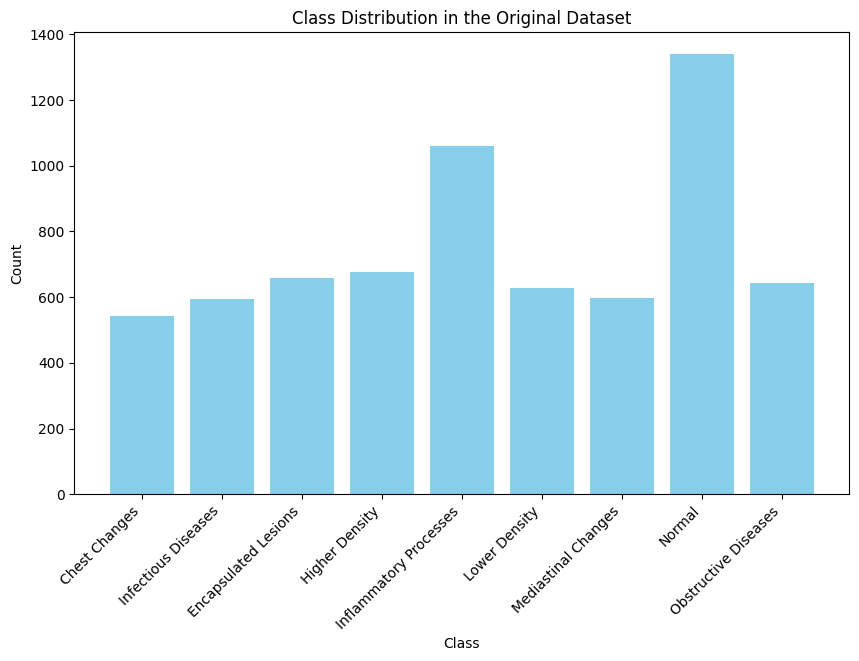

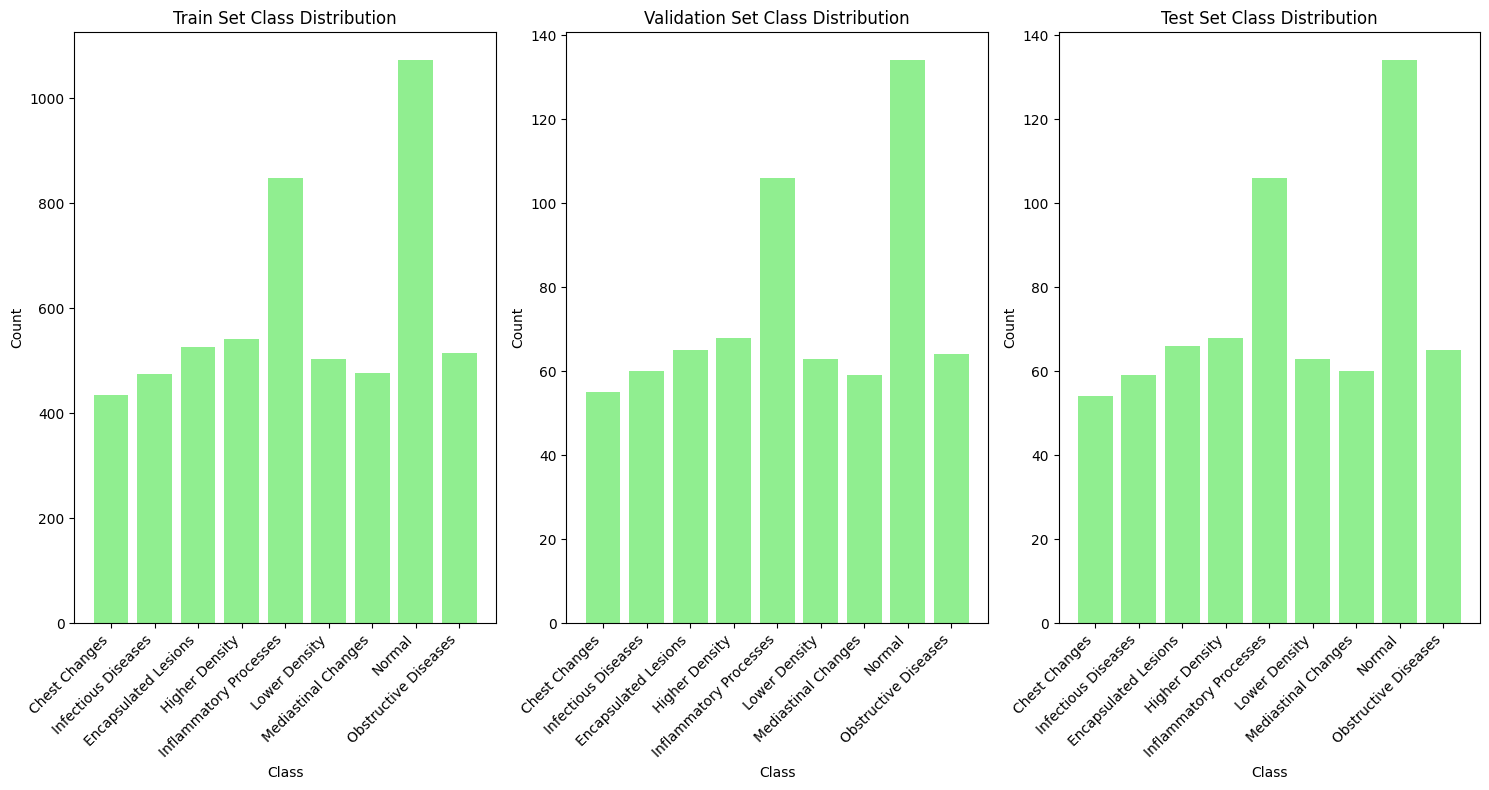

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Class labels
class_labels = {
    0: "Chest Changes",
    1: "Infectious Diseases",
    2: "Encapsulated Lesions",
    3: "Higher Density",
    4: "Inflammatory Processes",
    5: "Lower Density",
    6: "Mediastinal Changes",
    7: "Normal",
    8: "Obstructive Diseases",
}

# Count the occurrences of each class in the original dataset
class_counts = np.sum(y, axis=0)  # Summing one-hot encoded labels along rows

# Plot class distribution in the entire dataset
plt.figure(figsize=(10, 6))
plt.bar(class_labels.values(), class_counts, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution in the Original Dataset")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Analyze distributions in Train, Validation, and Test sets
sets = {
    "Train": y_train,
    "Validation": y_val,
    "Test": y_test
}

plt.figure(figsize=(15, 8))

for i, (set_name, set_data) in enumerate(sets.items(), 1):
    plt.subplot(1, 3, i)
    set_counts = np.sum(set_data, axis=0)
    plt.bar(class_labels.values(), set_counts, color="lightgreen")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"{set_name} Set Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


# Creating Batches and Prefetching

In [7]:
# Data augmentation (for training)
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomFlip("horizontal"),
    # Add more augmentations if needed
])

# Function for preparing the data pipeline for training and validation
def prepare_data(X, y, batch_size=BATCH_SIZE, is_train=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if is_train:
        dataset = dataset.shuffle(buffer_size=len(X))  # Adjust buffer size for large datasets
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_ds = prepare_data(X_train, y_train, batch_size=BATCH_SIZE, is_train=True)
val_ds = prepare_data(X_val, y_val, batch_size=BATCH_SIZE, is_train=False)
test_ds = prepare_data(X_test, y_test, batch_size=BATCH_SIZE, is_train=False)



In [ ]:
for images, labels in train_ds.take(1):  # Get one batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape, y_train.shape, y_val.shape)

# Model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_labels)

# ResNet50
base_model = tf.keras.applications.ResNet50V2(
    include_top = False,
    weights = 'imagenet',
    input_shape = INPUT_SHAPE
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce dimensionality
    BatchNormalization(),      # Normalize feature maps
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(n_classes, activation='softmax')  # 9 classes

])

# Define Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:  # Adjust learning rate every 5 epochs
        return lr * 0.5  # Reduce learning rate by half
    return lr

scheduler = LearningRateScheduler(lr_scheduler)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best weights when stopping
)

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Training Model

In [10]:
model.load_weights('checkpoint_epoch_.weights.h5')

In [ ]:
# Step 5: Train the Model
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    initial_epoch=5,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose = 1,
    #class_weight=class_weights, 
    callbacks=[early_stopping,scheduler]
)


Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9202 - loss: 0.2411 - val_accuracy: 0.9184 - val_loss: 0.2892 - learning_rate: 2.5000e-04
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.9448 - loss: 0.2039 - val_accuracy: 0.9288 - val_loss: 0.2438 - learning_rate: 2.5000e-04
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9381 - loss: 0.1923 - val_accuracy: 0.9436 - val_loss: 0.2187 - learning_rate: 2.5000e-04
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9590 - loss: 0.1509 - val_accuracy: 0.9436 - val_loss: 0.1986 - learning_rate: 2.5000e-04
Epoch 10/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9499 - loss: 0.1702 - val_accuracy: 0.9451 - val_loss: 0.1971 - learning_rate: 2.5000e-04
Epoch 11/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9580 - loss: 0.1423 - val_accuracy: 0.9540 - val_loss: 0.1883 - learning_rate: 1.2500e-04
Epoch 12/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.96

# Evaluation

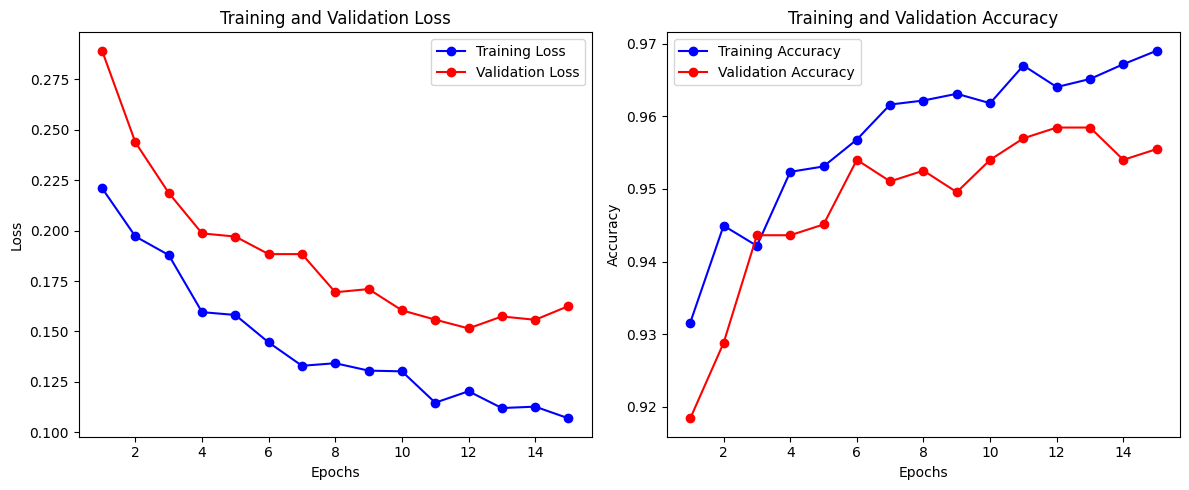

In [17]:
# Plot Training and Validation Metrics
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# Evaluate the Model
test_loss, test_acc = model.evaluate(test_ds) 
print(f"Test Accuracy: {test_acc * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9577 - loss: 0.1403
Test Accuracy: 94.52%


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.92      0.98      0.95        59
           2       1.00      0.95      0.98        66
           3       0.97      0.96      0.96        68
           4       0.86      0.89      0.87       106
           5       0.97      0.95      0.96        63
           6       1.00      1.00      1.00        60
           7       0.93      0.96      0.95       134
           8       0.95      0.85      0.89        65

    accuracy                        

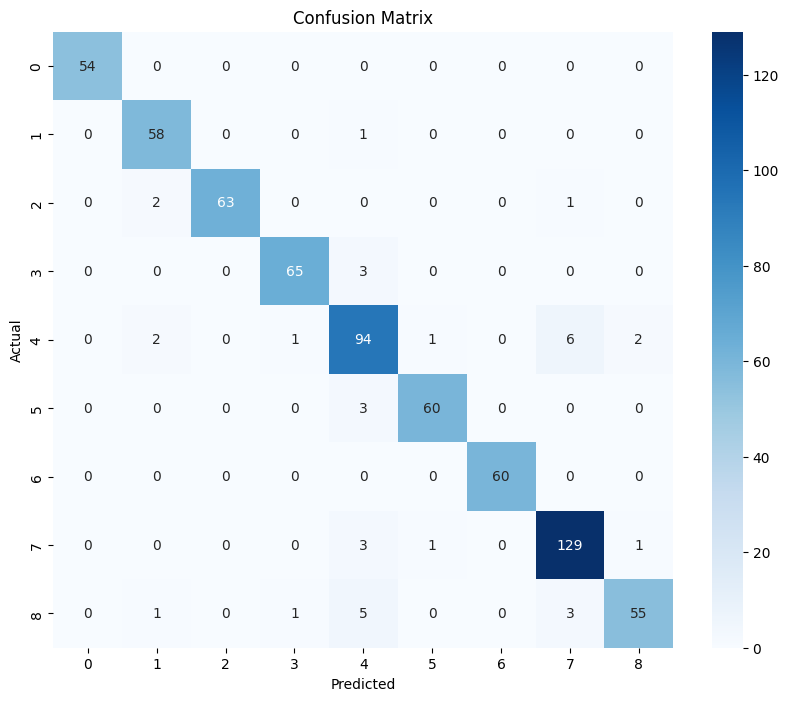

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    y_true.extend(labels.numpy().argmax(axis=1))  # True labels
    predictions = model.predict(images)
    y_pred.extend(predictions.argmax(axis=1))  # Predicted labels

# Convert class_labels to strings if needed
class_labels = [str(label) for label in class_labels]  # Ensure all labels are strings

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [30]:
model.save_weights('checkpoint_epoch_.weights.h5')
